# **Project assignment problem**

***assignment.ipynb***

One-to-one assignment of $n$ projects to $n$ persons to maximize the overall preference level. 

&copy; Copyright 2025-2026 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

## Problem description and formulation



There are $n$ persons and $n$ projects.  Each person $i \in \mathcal{I}$ ranks every project $j \in \mathcal{J}$ with a non-negative integer preference score $p_{i,j}$.  The goal is to find a one‑to‑one matching between persons and projects that maximizes the total satisfaction across all assignments. 

Let $x_{i,j}$ be the set of **binary decision variables** indicating if person $i$ is assigned to project $j$ (=1), or not (=0). The objective function aims to maximize the total satisfaction:

$$
\max \sum_{i\in \mathcal{I}}\sum_{j\in \mathcal{J}} p_{i,j}\,x_{i,j}.
$$

Subject to the following constraints:

* One project per person:
   $$
   \sum_{j\in \mathcal{J}} x_{i,j} = 1,
   \quad\forall\,i\in \mathcal{I}.
   $$

* One person per project:
   $$
   \sum_{i\in \mathcal{I}} x_{i,j} = 1,
   \quad\forall\,j\in \mathcal{J}.
   $$

In [ ]:
# Install the necessary packages
%pip install -q xpress matplotlib

## Data preparation

First, we import the necessary libraries for the notebook. We then define the preference matrix `PREF`, where each entry `PREF[i, j]` captures how much person $i$ values project $j$. From this matrix, we infer the number of persons and projects, and establish simple Python ranges (`people` and `projects`) to list them.

In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt

# Assignment
# Preference matrix: rows = persons, columns = projects
PREF = np.array([
    [1, 2, 3, 5, 4],
    [3, 2, 5, 4, 1],
    [3, 4, 1, 5, 2],
    [4, 3, 2, 5, 1],
    [2, 3, 5, 4, 1]
])

num_people, num_projects = PREF.shape
people = range(num_people)
projects = range(num_projects)

## Model implementation

We instantiate an Xpress model named **Assignment**, and create the set of binary decision variables. By passing integer arguments to [p.addVariables()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html), a *NumPy* array of variables (`assign`) is created.

The objective and constraints are then created and added to the problem by passing the corresponding expressions, using list comprehension, to [p.setObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) and [p.addConstraint()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addConstraint.html), respectively.

After building the model, we turn off solver logging using the `OUTPUTLOG` control and call [p.optimize()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.optimize.html) to solve the problem, then extract and display the total satisfaction as well as each individual assignment. 

In [ ]:
p = xp.problem(name="Assignment")

# Decision variables: matrix of binary variables x[i,j]
assign = p.addVariables(num_people, num_projects, vartype=xp.binary, name="x")

# Objective Function: Maximum overall preference
obj = xp.Sum(PREF[i, j] * assign[i, j] for i in people for j in projects)
p.setObjective(obj, sense=xp.maximize)

# Constraint 1: one project per person
p.addConstraint(xp.Sum(assign[i, j] for j in projects) == 1 for i in people)

# Constraint 2: one person per project
p.addConstraint(xp.Sum(assign[i, j] for i in people) == 1 for j in projects)

# Solve the problem
p.controls.outputlog = 0        # Turn off solver logging for cleaner output
p.optimize()

# Get solution
sol = p.getSolution(assign)
total_satisfaction = p.attributes.objval

# Print results
print("Total satisfaction score:", total_satisfaction)
for i in people:
    j = int(np.argmax(sol[i]))
    print(f"Person {i+1}: project {j+1}")

Total satisfaction score: 21.0
Person 1: project 5
Person 2: project 3
Person 3: project 4
Person 4: project 1
Person 5: project 2


## Visualization

After running the code cell below, we can visualize the assignment as a bipartite graph with persons on the left, projects on the right, and lines whose **thickness reflects preference connecting each matched pair** connecting both sides.  

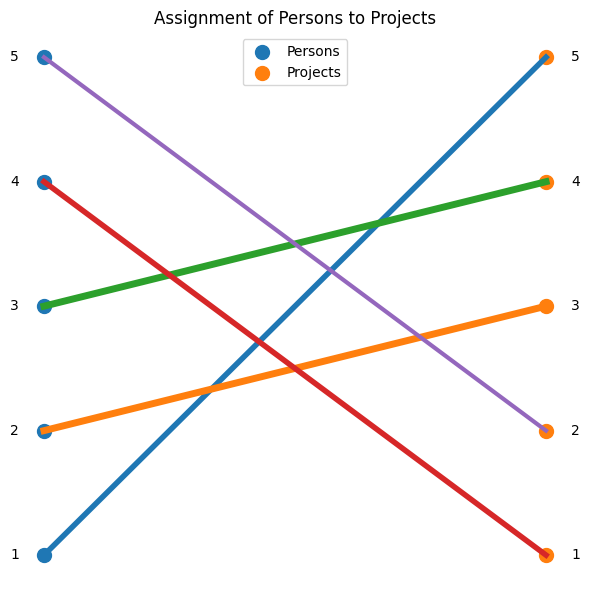

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
left_x, right_x = 0, 2

y_people = np.arange(1, num_people + 1)
y_projects = np.arange(1, num_projects + 1)
ax.scatter([left_x]*num_people, y_people, s=100, label="Persons")
ax.scatter([right_x]*num_projects, y_projects, s=100, label="Projects")

# Add node labels
txt_offset = 0.1
for i in people:
    ax.text(left_x - txt_offset, i+1, str(i+1), ha='right', va='center')
for j in projects:
    ax.text(right_x + txt_offset, j+1, str(j+1), ha='left', va='center')

for i in people:
    j = int(np.argmax(sol[i]))
    pref = PREF[i, j]
    ax.plot([left_x, right_x], [i+1, j+1], linewidth=pref)
ax.axis('off')
ax.set_title('Assignment of Persons to Projects')
ax.legend(loc='upper center')
plt.tight_layout()
plt.show()